In [1]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import tensorflow as tf


2021-10-18 15:05:43.683743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 15:05:43.683775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data")
MODELS_FOLDER = os.path.join(this_folder, "models")

In [3]:
def load_image(filename):
    image = Image.open(os.path.join(DATA_FOLDER, filename))
    return image

In [4]:
def predict_image(image, model):
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)


In [15]:
def display_slice_and_predictions(coupe, predicted_locations):
    linewidth=3
    color=[0, 0, 1]
    label_to_text = {
        0: "Negative",
        1: "Primordial", 
        2: "Primary", 
        3: "Secondary", 
        4: "Tertiary", 
    }
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(coupe)
    ax = plt.gca()
    for prediction in predicted_locations:
        box = prediction["bbox"]
        label = prediction["label"]
        label_text = label_to_text[label]
        proba = prediction["proba"]

        text = "{}: {:.2f}".format(label_text, proba)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 1},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()

In [10]:
def generate_grid_for_image(image, box_width_pixels=800):
    """generator of square boxes that create a grid overlay for the given image"""
    width = box_width_pixels
    stride = width // 2

    x1 = 0
    y1 = 0
    while True:
        while True:
            bbox = (x1, y1, x1 + width, y1 + width)
            yield bbox

            x1 = x1 + stride
            if x1 + width > image.width:
                break
        x1 = 0
        y1 += stride

        if y1 + width > image.height:
            break



In [35]:
IMAGE_TO_ANALYSE = 'D-1M01-3.jpg'
MODEL_PATH = os.path.join(MODELS_FOLDER, "classifier")
WIDTH_OF_GRID_PIXELS = 200
PROBA_THRESHOLD = 0.0

In [24]:
coupe = load_image(IMAGE_TO_ANALYSE)

In [25]:
model_loaded = tf.keras.models.load_model(MODEL_PATH)
model_loaded

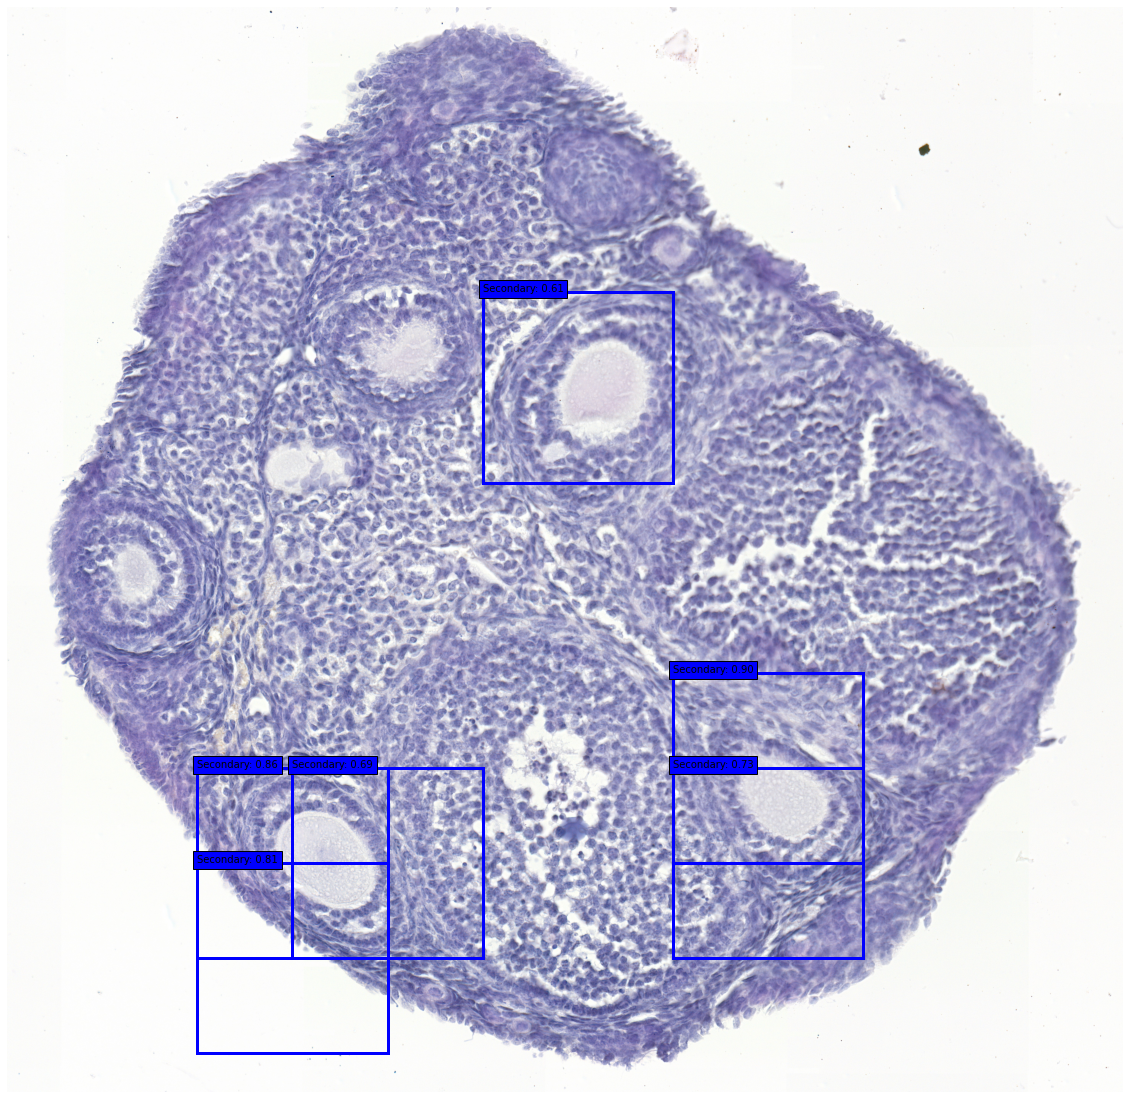

In [42]:

def predict_locations_for_gridsize(coupe, box_width_pixels, model):
    boxes = generate_grid_for_image(coupe, box_width_pixels=box_width_pixels)
    predicted_locations = []
    for box in boxes:
        cropped_image = coupe.crop(box)
        label, proba = predict_image(cropped_image, model)
        predicted_locations.append({
                "bbox": box,
                "label": label,
                "proba": proba
            })
    return predicted_locations

def filter_predictions(predicted_locations, proba_threshold=0.6):
    def should_keep_prediction(label, proba):
        if label == 0:
            return False
        if proba < proba_threshold:
            return False
        return True

    selected_locations = [
        prediction
        for prediction in predicted_locations
        if should_keep_prediction(prediction["label"], prediction["proba"])
    ]

    return selected_locations
        
#

predicted_locations = predict_locations_for_gridsize(coupe, 1000, model_loaded)
selected_locations = filter_predictions(predicted_locations)
display_slice_and_predictions(coupe, selected_locations)


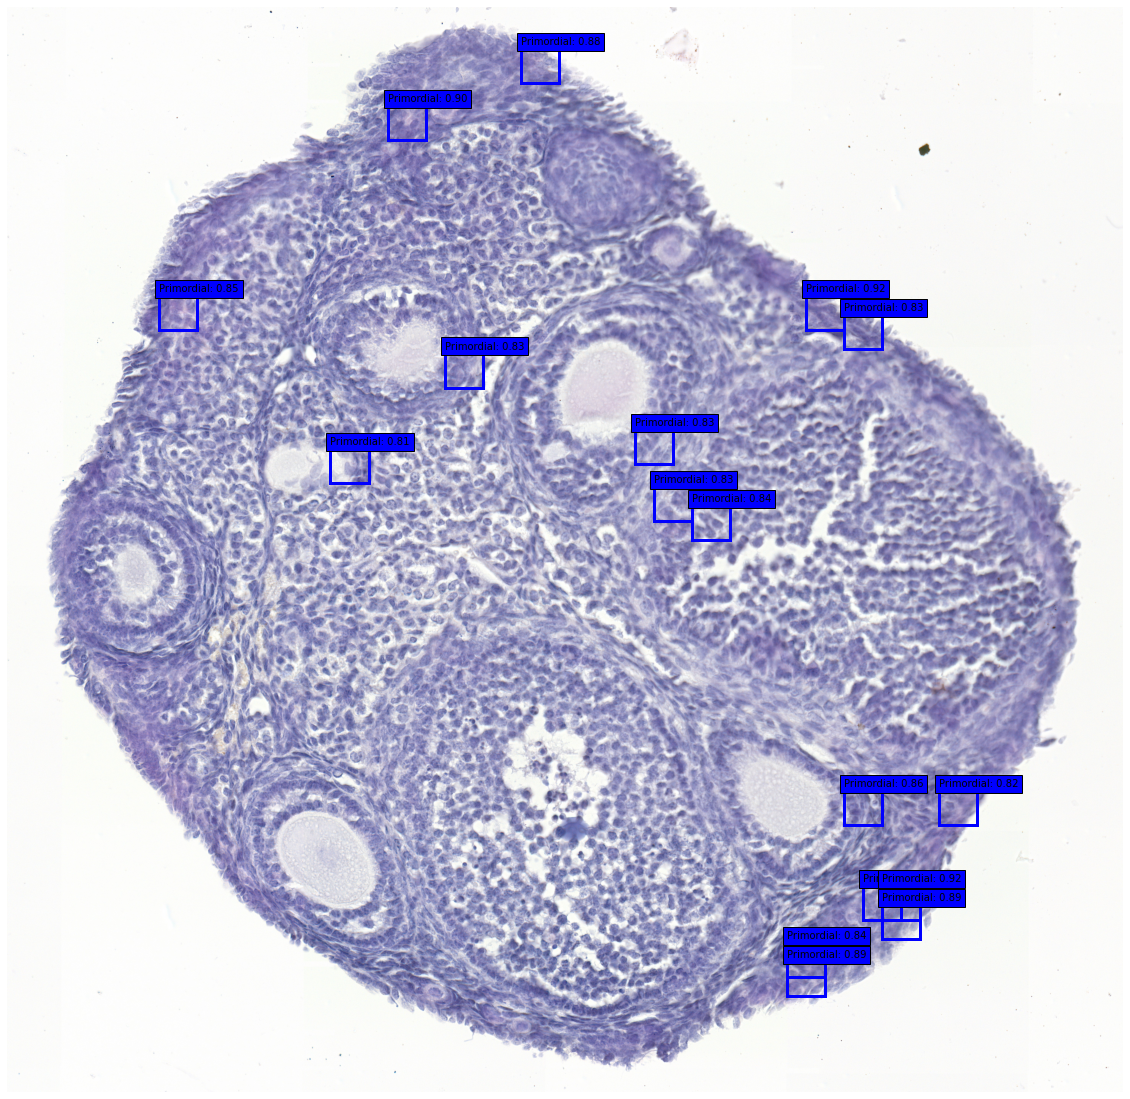

In [43]:
predicted_locations = predict_locations_for_gridsize(coupe, 200, model_loaded)
selected_locations = filter_predictions(predicted_locations, proba_threshold=0.8)
display_slice_and_predictions(coupe, selected_locations)
